In [91]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm, metrics
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, roc_auc_score
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer

In [69]:
train_data = pd.read_csv("handout/train_features.csv", delimiter=",")
train_labels = pd.read_csv("handout/train_labels.csv", delimiter=",")
test_data = pd.read_csv("handout/test_features.csv", delimiter=",")

# If implace with sklearn, do it here
train_data["svc_weights"] = train_data.notna().sum(axis=1)
imputer = SimpleImputer(strategy='mean')
imputer.fit(train_data)
train_data_implaced = imputer.transform(train_data)
train_data_implaced = pd.DataFrame(train_data_implaced, columns=train_data.columns)
train_data_implaced = train_data_implaced.sort_values(['pid', 'Time'])
train_data_implaced = train_data_implaced.set_index("pid")

train_data = train_data.sort_values(['pid','Time'])
train_labels = train_labels.sort_values(['pid'])
test_data = test_data.sort_values(['pid','Time'])

train_data = train_data.set_index("pid")
train_data = train_data.sort_index()
train_labels = train_labels.set_index("pid")
train_labels = train_labels.sort_index()
test_data = test_data.set_index("pid")
test_data = test_data.sort_index()

# Data Imputation

See https://machinelearningmastery.com/statistical-imputation-for-missing-values-in-machine-learning/

A simple and popular approach to data imputation involves using statistical methods to estimate a value for a column from those values that are present, then replace all missing values in the column with the calculated statistic.

Common statistics calculated include:

- The column mean value.
- The column median value.
- The column mode value.
- A constant value.

In [4]:
for column in train_data.columns:
    missing_values = train_data[column].isnull().sum()
    print("Missing values in column {}: {} ({:.3f}%)".format(column, missing_values, missing_values / train_data.shape[0] * 100))

Missing values in column Time: 0 (0.000%)
Missing values in column Age: 0 (0.000%)
Missing values in column EtCO2: 218157 (95.708%)
Missing values in column PTT: 217641 (95.482%)
Missing values in column BUN: 207835 (91.180%)
Missing values in column Lactate: 217184 (95.281%)
Missing values in column Temp: 146825 (64.414%)
Missing values in column Hgb: 205645 (90.219%)
Missing values in column HCO3: 215381 (94.490%)
Missing values in column BaseExcess: 208053 (91.275%)
Missing values in column RRate: 40155 (17.616%)
Missing values in column Fibrinogen: 225447 (98.906%)
Missing values in column Phosphate: 216350 (94.915%)
Missing values in column WBC: 208857 (91.628%)
Missing values in column Creatinine: 210148 (92.194%)
Missing values in column PaCO2: 206897 (90.768%)
Missing values in column AST: 222179 (97.473%)
Missing values in column FiO2: 201338 (88.329%)
Missing values in column Platelets: 209905 (92.088%)
Missing values in column SaO2: 214926 (94.291%)
Missing values in column 

In [184]:
def custom_implace(df):
    """ Given an indexed dataframe and a dictionary of global means computed from it, imputes missing values.
    The idea is that for each patient (identified by pid, each patient having 12 rows) for each feature, we check 
    how many values are missing. If ALL of them are missing, we impute the global mean for that feature.
    If only some of them are missing, we impute the mean of the non-missing values.

    Since the dataframe is modified in place, we return the modified dataframe, so the right syntax is:
    df = custom_implace(df, global_means)

    Mini Test:
    train_df_reindex = train_df.set_index("pid")
    x = train_df_reindex.loc[[1,2]]
    x = x[["Time", "Age", "PTT", "BUN", "Heartrate"]]
    xc = custom_implace(x)
    """
    pids = list(set(df.index.values))
    global_means = df.mean()
    sfs = []

    for pid in pids:
        sf = df.loc[pid]
        local_means = sf.mean()
        new_means = global_means.copy()
        new_means = new_means.where(sf.isna().all(), other=local_means, inplace=False)
        sf = sf.fillna(new_means)
        sfs.append(sf)
    
    df = pd.concat(sfs, axis=0) 
    
    return df

In [185]:
#train_data_implaced = custom_implace(train_data)

In [5]:
# Make a dataframe for the labels which has the same lenght as the train dataframe, 
# i.e. replicate the labels for each time point for each patient
# To run only if custom_implace was called with reduce=False

train_labels_12 = pd.concat([train_labels] * 12, axis=0)
train_labels_12 = train_labels_12.sort_index()

In [7]:
# Some plots to help visualize
#features_combinations = list(combinations(train_df_reindex_imputed.columns[6:], 2))[:10]
features_combinations = list(combinations(["RRate", "ABPm", "ABPd", "SpO2", "Heartrate", "ABPs"], 2))
def plot_feature_comparison(train_data, train_labels, features_combinations, labels):
    tot_df = pd.concat([train_data, train_labels], axis=1)
    for label in labels:
        label0 = tot_df[tot_df[label] == 0]
        label1 = tot_df[tot_df[label] == 1]
        fig, ax = plt.subplots(len(features_combinations), 1, figsize=(5, 5 * len(features_combinations)))
        for i, (feature0, feature1) in enumerate(features_combinations):
            df0 = label0[[feature0, feature1]]
            df1 = label1[[feature0, feature1]]
            ax[i].scatter(df0[feature0], df0[feature1], c="red", marker="o", label="0")
            ax[i].scatter(df1[feature0], df1[feature1], c="blue", marker="o", label="1", alpha=0.3)
            ax[i].set_xlabel(feature0)
            ax[i].set_ylabel(feature1);
            ax[i].legend()
    
    plt.show();

## Subtask1

In [94]:
def balance_dataset(train_data, train_labels, features, label):
    """ 
    """
    tot_df = pd.concat([train_data, train_labels], axis=1)

    # Cuts and stuff
    tot_df = tot_df[tot_df["svc_weights"] > 15]

    tot_df0 = tot_df[tot_df[label] == 0]
    tot_df1 = tot_df[tot_df[label] == 1]
    n = min(tot_df0.shape[0], tot_df1.shape[0])
    tot_df0_sampled = tot_df0.sample(n=n)
    tot_df1_sampled = tot_df1.sample(n=n)
    tot_df_sampled = pd.concat([tot_df0_sampled, tot_df1_sampled], axis=0)
    tot_df_sampled = shuffle(tot_df_sampled)
    train_data_sampled = tot_df_sampled[features]
    train_labels_sampled = tot_df_sampled[label]

    return train_data_sampled, train_labels_sampled

In [95]:
labels = ['BaseExcess', 'Fibrinogen', 'AST', 'Alkalinephos', 'Bilirubin_total', 'Lactate', 'TroponinI', 'SaO2', 'Bilirubin_direct', 'EtCO2']
# only to test
#labels = ["Fibrinogen"]
labels = [f"LABEL_{label}" for label in labels]

LABEL_BaseExcess
ROC AUC: 0.7348764440309126
LABEL_Fibrinogen
ROC AUC: 0.7523393457695193
LABEL_AST
ROC AUC: 0.7372025330919719
LABEL_Alkalinephos
ROC AUC: 0.7180436679185138
LABEL_Bilirubin_total
ROC AUC: 0.7199785174015032
LABEL_Lactate
ROC AUC: 0.6935468755229776
LABEL_TroponinI
ROC AUC: 0.6939489082346225
LABEL_SaO2
ROC AUC: 0.7125248206966579
LABEL_Bilirubin_direct
ROC AUC: 0.6747684708787817
LABEL_EtCO2
ROC AUC: 0.7539470239848173


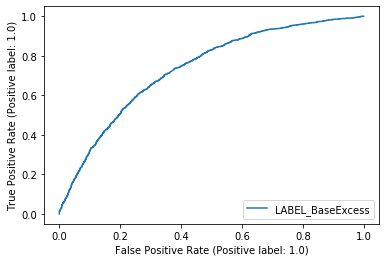

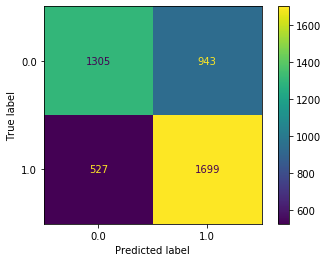

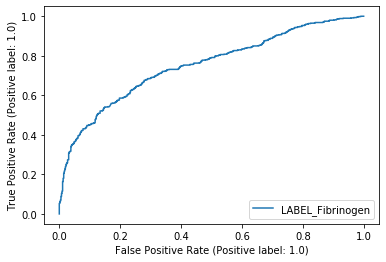

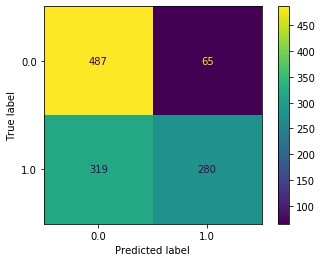

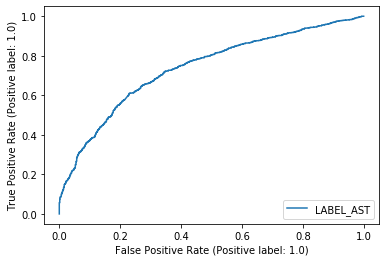

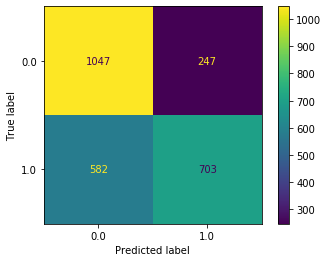

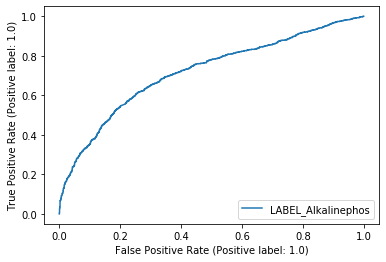

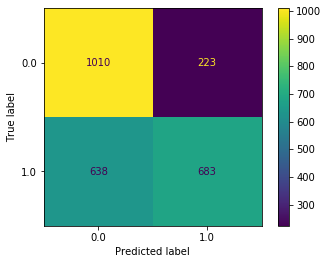

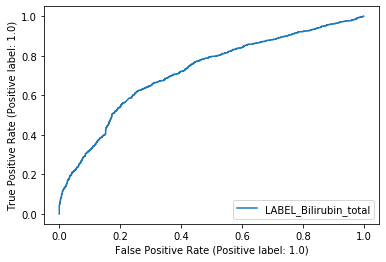

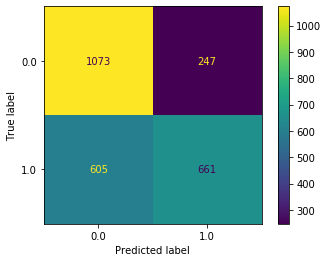

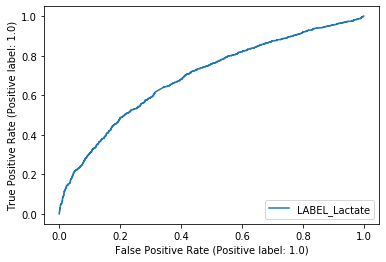

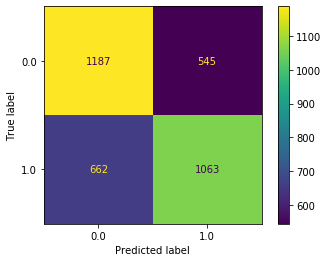

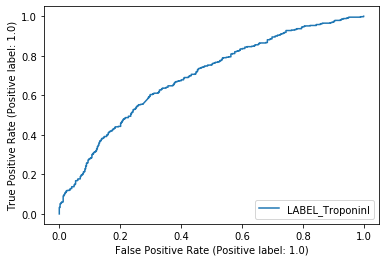

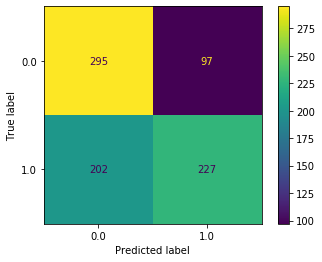

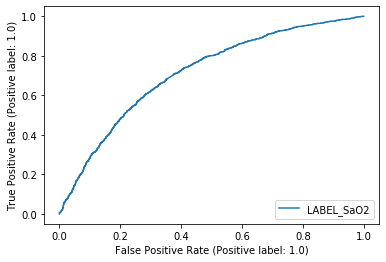

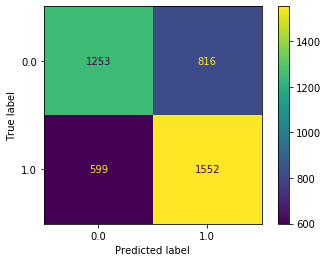

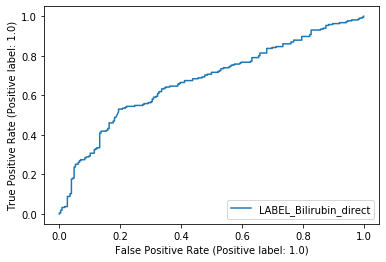

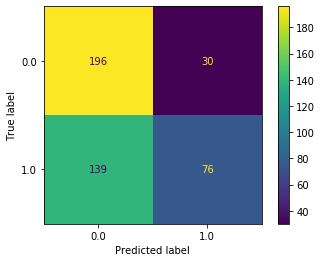

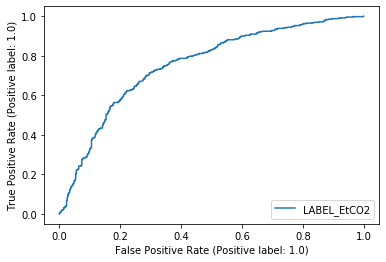

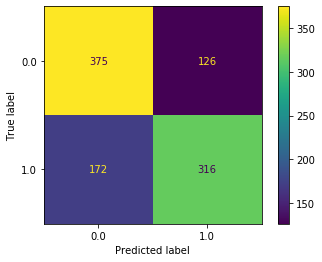

In [97]:
interesting_features = [c for c in train_data_implaced.columns if c not in ["Time"]]

for label in labels:
    train_data_balanced, train_labels_balanced = balance_dataset(train_data_implaced, train_labels_12, interesting_features, label)
    X_train, X_test, y_train, y_test = train_test_split(train_data_balanced, train_labels_balanced, test_size=0.2, random_state=42)
    
    weights = X_train["svc_weights"]
    X_train = X_train.drop(columns=["svc_weights"])
    X_test = X_test.drop(columns=["svc_weights"])

    clf = svm.SVC(kernel="rbf", probability=True, class_weight="balanced")
    clf.fit(X_train, y_train, sample_weight=weights)

    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    # Evaluation
    print(label)
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba)}")
    plot_roc_curve(clf, X_test, y_test, label=label)
    plot_confusion_matrix(clf, X_test, y_test)

## Subtask2

In [102]:
def balance_dataset(train_data, train_labels, features, label):
    """ 
    """
    tot_df = pd.concat([train_data, train_labels], axis=1)

    # Cuts and stuff
    tot_df = tot_df[tot_df["svc_weights"] > 18]

    tot_df0 = tot_df[tot_df[label] == 0]
    tot_df1 = tot_df[tot_df[label] == 1]
    n = min(tot_df0.shape[0], tot_df1.shape[0])
    tot_df0_sampled = tot_df0.sample(n=n)
    tot_df1_sampled = tot_df1.sample(n=n)
    tot_df_sampled = pd.concat([tot_df0_sampled, tot_df1_sampled], axis=0)
    tot_df_sampled = shuffle(tot_df_sampled)
    train_data_sampled = tot_df_sampled[features]
    train_labels_sampled = tot_df_sampled[label]

    return train_data_sampled, train_labels_sampled

In [99]:
label = "LABEL_Sepsis"

In [105]:
# Split the data into training and test sets
interesting_features = [c for c in train_data_implaced.columns if c not in ["Time"]]
#interesting_features = ["RRate", "ABPm", "ABPd", "SpO2", "Heartrate", "ABPs"]
train_data_balanced, train_labels_balanced = balance_dataset(train_data_implaced, train_labels_12, interesting_features + ["r", "theta"], label)
X_train, X_test, y_train, y_test = train_test_split(train_data_balanced, train_labels_balanced, test_size=0.2, random_state=42)

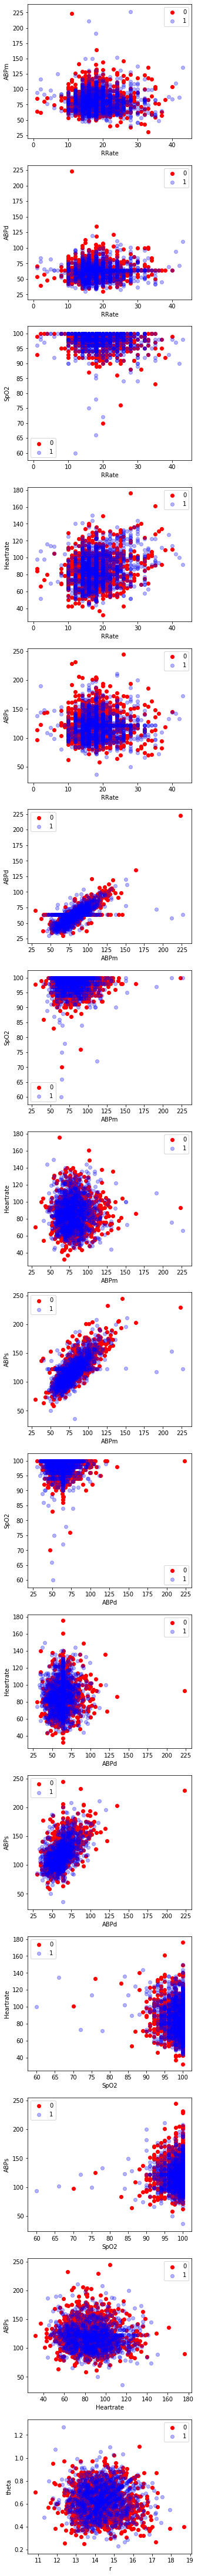

In [106]:
plot_feature_comparison(X_train, y_train, features_combinations + [("r", "theta")], [label])

In [79]:
weights = X_train["svc_weights"]
X_train = X_train.drop(columns=["svc_weights"])
X_test = X_test.drop(columns=["svc_weights"])

In [80]:
classifier = svm.SVC(kernel="rbf", probability=True, class_weight="balanced")
classifier.fit(X_train, y_train, sample_weight=weights)

SVC(class_weight='balanced', probability=True)

In [67]:
y_pred = classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred, normalize='true'))
#print(classification_report(y_test, y_pred))

[[0.64157706 0.35842294]
 [0.49825784 0.50174216]]


In [82]:
y_probs = classifier.predict_proba(X_test)

Column: ROC AUC: 0.60


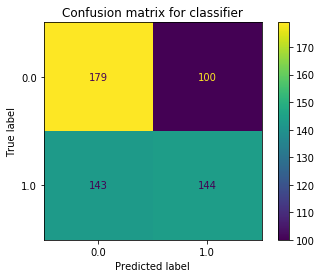

In [68]:
y_pred = classifier.predict_proba(X_test)
y_pred = pd.DataFrame(data=y_pred, columns=['prob_0','prob_1'])
print("Column: ROC AUC: %.2f" %(metrics.roc_auc_score(y_test, y_pred['prob_1'])))
# confusion matrix
matrix = plot_confusion_matrix(classifier, X_test, y_test)
plt.title('Confusion matrix for classifier')
plt.show(matrix)
plt.show()